# Uploading data files (If using colab)
Required files
- Google_Stock_Price_Train.csv
- Google_Stock_Price_Test.csv

In [1]:
import os
import importlib
train_file_name = 'Google_Stock_Price_Train.csv'
test_file_name = 'Google_Stock_Price_Test.csv'
try:
  colab = importlib.util.find_spec('google.colab')
  if colab is None:
    raise ImportError('Not working in colab')
  
  from google.colab import files
  if not train_file_name in os.listdir():
    print("Please upload", train_file_name)
    files.upload()
  if not test_file_name in os.listdir():
    print("Please upload", test_file_name)
    files.upload()
  print("Files ready")
except ImportError as e:
  pass

if train_file_name not in os.listdir():
    print("Could not find file {} in the current directory".format(train_file_name))
    print("Please ensure the file is present in the current directory before executing the code")
    exit(1)
if test_file_name not in os.listdir():
    print("Could not find file {} in the current directory".format(test_file_name))
    print("Please ensure the file is present in the current directory before executing the code")
    exit(1)

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Data preprocessing

In [3]:
dataset = pd.read_csv('Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)

# See sample data
dataset.head()

Open    High     Low   Close      Volume
Date                                                  
2012-01-03  325.25  332.83  324.97  663.59   7,380,500
2012-01-04  331.27  333.87  329.08  666.45   5,749,400
2012-01-05  329.83  330.75  326.89  657.21   6,590,300
2012-01-06  328.34  328.77  323.68  648.24   5,405,900
2012-01-09  322.04  322.29  309.46  620.76  11,688,800

In [4]:
# Check for missing data
dataset.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [5]:
# See dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


## Fixing data types
There are columns having numeric values in american notation (having commas), it should be converted to float for training

In [6]:
# convert close and volume into float type
dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)
dataset["Volume"] = dataset["Volume"].str.replace(',', '').astype(float)

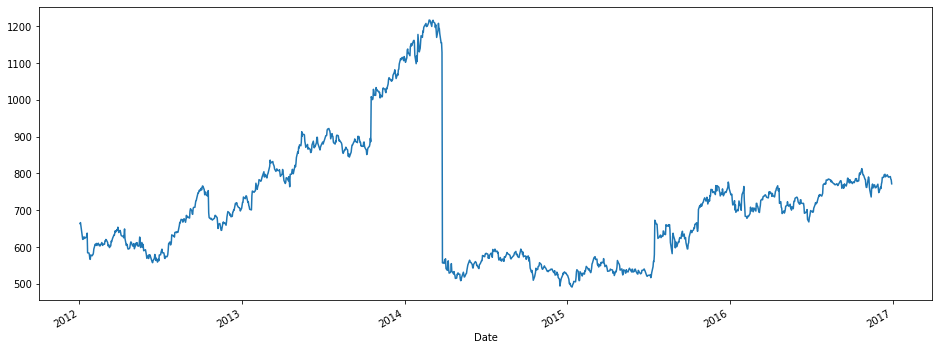

In [7]:
# Plot a sample feature
dataset['Close'].plot(figsize=(16,6))

## Training method
A day's features are predicted based on data from previous 60 days. This is implemented by using a many to many recurrent neural network.

In [8]:
training_set=dataset[['Open', 'High', 'Low', 'Close', 'Volume']]

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)

# Constructing recurrent neural network

In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout



Using TensorFlow backend.


In [10]:
# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 5))



# Training and evaluation

In [11]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)


Train on 958 samples, validate on 240 samples
Epoch 1/5
958/958 [==============================] - 31s 33ms/step - loss: 0.0237 - val_loss: 0.0056
Epoch 2/5
958/958 [==============================] - 31s 32ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 3/5
958/958 [==============================] - 45s 47ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 4/5
958/958 [==============================] - 44s 46ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 5/5
958/958 [==============================] - 45s 47ms/step - loss: 0.0065 - val_loss: 0.0031


# Preprocessing test data

In [12]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv',index_col="Date",parse_dates=True)
dataset_test.head()

Open    High     Low   Close     Volume
Date                                                 
2017-01-03  778.81  789.63  775.80  786.14  1,657,300
2017-01-04  788.36  791.34  783.16  786.90  1,073,000
2017-01-05  786.08  794.48  785.02  794.02  1,335,200
2017-01-06  795.26  807.90  792.20  806.15  1,640,200
2017-01-09  806.40  809.97  802.83  806.65  1,272,400

In [13]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     object 
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


## Fixing data types
There are columns having numeric values in american notation (having commas), it should be converted to float for training

In [14]:
dataset_test["Volume"] = dataset_test["Volume"].str.replace(',', '').astype(float)

In [15]:
test_set=dataset_test[['Open', 'High', 'Low', 'Close', 'Volume']]
real_stock_price = dataset_test.values[:, :]

In [16]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     float64
dtypes: float64(5)
memory usage: 960.0 bytes


# Forecasting
Iteratively, a days feature values are predicted using a rolling window of 60 days' data. Each iteration will append its prediction to the known data so that the rolling window can move forward in each iteration.

In [17]:
# Getting the predicted stock price of 2017
inputs = dataset.values[-60:, :]
inputs = sc.transform(inputs)
inputs = inputs.reshape(1, -1, 5)
predicted_stock_price = None
for i in range(60, 80):
    prediction = model.predict(inputs)
    if type(predicted_stock_price) == type(None):
        predicted_stock_price = prediction
    else:
        predicted_stock_price = np.concatenate([predicted_stock_price, prediction], axis=0)
    inputs = np.concatenate([inputs, prediction.reshape(1, -1, 5)], axis=1)[:, 1:, :]
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20 non-null     float32
 1   1       20 non-null     float32
 2   2       20 non-null     float32
 3   3       20 non-null     float32
 4   4       20 non-null     float32
dtypes: float32(5)
memory usage: 528.0 bytes


# Plotting Forecasts
A few timesteps of actual stock data is prepended to forecast data for better visualisation of graphs

In [18]:
forecast_data_expected = np.concatenate([dataset.values[-20:, :], real_stock_price], axis=0)
forecast_data_obtained = np.concatenate([dataset.values[-20:, :], predicted_stock_price], axis=0)

## Day opening prices

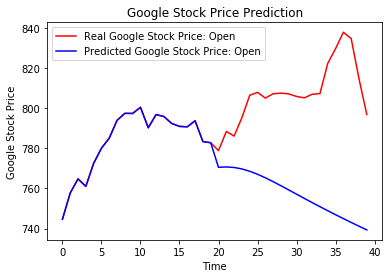

In [19]:
plt.clf()
# Visualising the results
plt.plot(forecast_data_expected[:, 0], color = 'red', label = 'Real Google Stock Price: Open')
plt.plot(forecast_data_obtained[:, 0], color = 'blue', label = 'Predicted Google Stock Price: Open')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("open-prices.png")
plt.show()

## Day highest prices

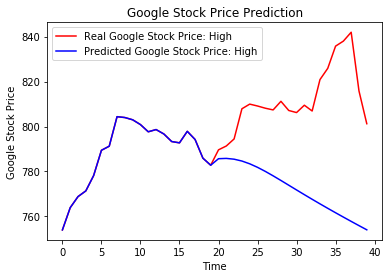

<Figure size 1152x432 with 0 Axes>

In [20]:
# Visualising the results
plt.plot(forecast_data_expected[:, 1], color = 'red', label = 'Real Google Stock Price: High')
plt.plot(forecast_data_obtained[:, 1], color = 'blue', label = 'Predicted Google Stock Price: High')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.figure(figsize=(16,6))
plt.savefig("high-prices.png")
plt.show()

## Day lowest prices

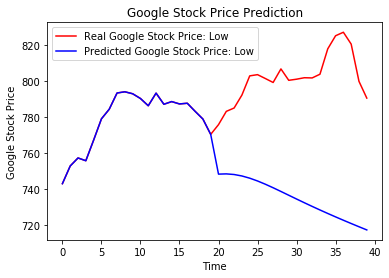

In [21]:
# Visualising the results
plt.plot(forecast_data_expected[:, 2], color = 'red', label = 'Real Google Stock Price: Low')
plt.plot(forecast_data_obtained[:, 2], color = 'blue', label = 'Predicted Google Stock Price: Low')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("low-prices.png")
plt.show()

## Day closing prices

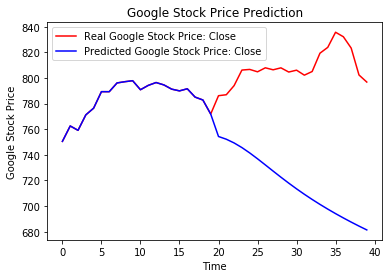

In [22]:
# Visualising the results
plt.plot(forecast_data_expected[:, 3], color = 'red', label = 'Real Google Stock Price: Close')
plt.plot(forecast_data_obtained[:, 3], color = 'blue', label = 'Predicted Google Stock Price: Close')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("close-prices.png")
plt.show()

## Day volumes

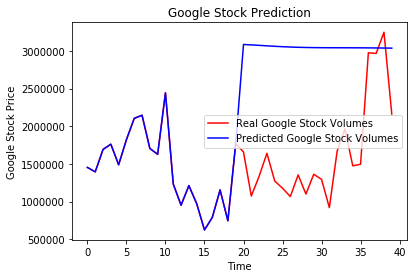

In [23]:
# Visualising the results
plt.plot(forecast_data_expected[:, 4], color = 'red', label = 'Real Google Stock Volumes')
plt.plot(forecast_data_obtained[:, 4], color = 'blue', label = 'Predicted Google Stock Volumes')
plt.title('Google Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig("volumes.png")
plt.show()